In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import os
import tqdm

import seaborn as sns
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.utils import make_grid
from attrdict import AttrDict
import torch
import yaml
from sklearn.model_selection import StratifiedKFold
import copy
import pickle
# from tqdm import tqdm_notebook

# additional lightning 

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule

import torch
from torch import nn
import torch.nn.functional as F
from timm import create_model

import gc

In [2]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
##################
# VM USE THIS
##################
import sys
sys.path.append("../")
from pawnet.utility import *


##################
# KAGGLE USE THIS
##################
# you need to import the utility script by uploading to kaggle as pawnet_utility/pawnet_utility.py
# from pawnet_utility import *

In [4]:
# extra augmentations for experiments
import pawnet.augmentations as aug_utils

In [5]:
# load config
# this object manages all the configurations
##################
# KAGGLE USE THIS
##################
# config_path = "../input/config/config.yaml"

##################
# VM USE THIS
##################
config_path = "../config/config.yaml"
base_config_manager = BaseConfigLoader(config_path)

In [6]:
##################
# KAGGLE USE THIS
##################
# this is specific to kaggle
# if running in GCS, replace with our GCP bucket
# get cache location of the dataset
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()
# file_path = base_config_manager.load_config().filepath.kaggle #"/kaggle/input/petfinder-pawpularity-score/"


##################
# VM USE THIS
##################
file_path = base_config_manager.load_config().filepath.gcs

train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))

# Load Data

In [7]:
model_config = base_config_manager.load_config().model.swin_tiny4_w7_224_cut1 # for general skf config
test_transformation = T.Compose([
                T.Resize([224,224]),# imgnet needs at least 224
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ), # imgnet requirements 
                ]
            )

seed_everything(1)
skf = StratifiedKFold(n_splits = model_config.n_splits, shuffle = True, random_state = 1)
splits = skf.split(train_df["Id"],train_df["Pawpularity"])

rmse_list = []

# get data loader for fold 0
for i, (train_index, test_index) in enumerate(splits):
    print("\n Starting: fold {}".format(i+1))
    X_train, X_valid = train_df.iloc[train_index], train_df.iloc[test_index]
    X_train.reset_index(inplace=True,drop=True)
    X_valid.reset_index(inplace=True,drop=True)
    
    valid_data = pawnetDataset(annotation_df=X_valid,img_dir =os.path.join(file_path,"train"), transform = test_transformation,test=True)
    valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=16,shuffle=False,num_workers=2)
    # without transformation
    test_data = pawnetDataset(annotation_df=X_valid,img_dir =os.path.join(file_path,"train"), transform = T.Compose([
                T.Resize([224,224]),# imgnet needs at least 224
                ]),test=True)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=16,shuffle=False,num_workers=2)
    break

Global seed set to 1



 Starting: fold 1


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


For the following sections, you need to run separately and not in 1 single run - else kernel will get error and die

In [47]:
# gradcam reshape_transform for vit [N,7,7,768] so H and W must be 7
def reshape_transform_func(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))
    # like in CNNs.
    result = result.permute(0, 3, 1, 2)
    return result

def check_gradcam(model, dataloader,og_dataloader,target_category, reshape_transform=None, model_type="swin"):
    if model_type == "swin":
        target_layer = model.pretrained.layers[-1].blocks[-1].mlp # swin_model.pretrained.layers[-1].blocks[-1].norm1
    elif model_type == "resnet":
        target_layer = model.pretrained.layer4[2].act2
    
    cam = GradCAMPlusPlus(
        model=model,
        target_layer=target_layer,
        use_cuda=1, 
        reshape_transform=reshape_transform)

    images, _ = iter(dataloader).next()
    org_images, labels = iter(og_dataloader).next()
    
    cam.batch_size = len(org_images)
    images = images.to("cuda")
    logits = model.forward(images).squeeze(1)
    pred = logits.sigmoid().detach().cpu().numpy() * 100
    labels = labels.cpu().numpy()

    grayscale_cam = cam(input_tensor=images, target_category=target_category, eigen_smooth=True)
    org_images = org_images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255.
    return org_images, grayscale_cam, pred, labels

In [41]:
resnet_model.pretrained.layer4[2]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
)

# Load Swin

In [13]:
model_config = base_config_manager.load_config().model.swin_tiny4_w7_224_cut1
criterion = torch.nn.BCEWithLogitsLoss()
swin_model = pawNetBasic.load_from_checkpoint(checkpoint_path=f"pawnet_lightning_swin_tiny4_w7_224_mixup04/default/version_0/checkpoints/best_loss.ckpt",criterion=criterion,model_config=model_config)

will perform cutmix


In [14]:
swin_model = swin_model.cuda().eval()

In [ ]:
images, grayscale_cams, preds, labels = check_gradcam(
                                            swin_model,
                                            valid_loader,
                                            test_loader,
                                            target_category=None,
                                            reshape_transform=reshape_transform_func)

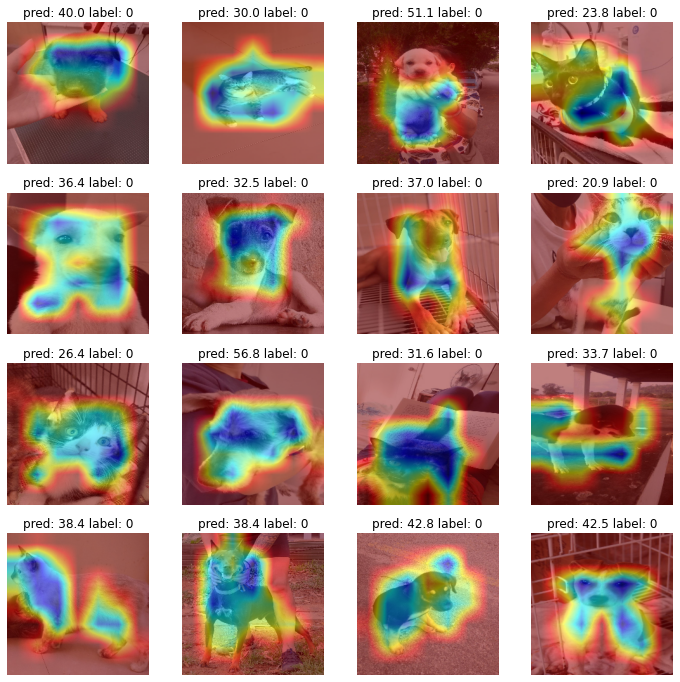

In [37]:

# this is from MLP in swin
plt.figure(figsize=(12, 12))
for it, (image, grayscale_cam, pred, label) in enumerate(zip(images, grayscale_cams, preds, labels)):
    plt.subplot(4, 4, it + 1)
    visualization = show_cam_on_image(image, grayscale_cam)
    plt.imshow(visualization)
    plt.title(f'pred: {pred:.1f} label: {label}')
    plt.axis('off')

# Load Resnet

In [9]:
model_config = base_config_manager.load_config().model.resnet34
criterion = torch.nn.BCEWithLogitsLoss()
resnet_model = pawNetBasic.load_from_checkpoint(checkpoint_path=f"02a-resnet/pawnet_lightning_resnet/default/version_0/checkpoints/best_loss.ckpt",criterion=criterion,model_config=model_config)

In [10]:
resnet_model = resnet_model.cuda().eval()

In [11]:
images, grayscale_cams, preds, labels = check_gradcam(
                                            resnet_model,
                                            valid_loader,
                                            test_loader,
                                            target_category=None,
                                            reshape_transform=None,
    model_type="resnet")

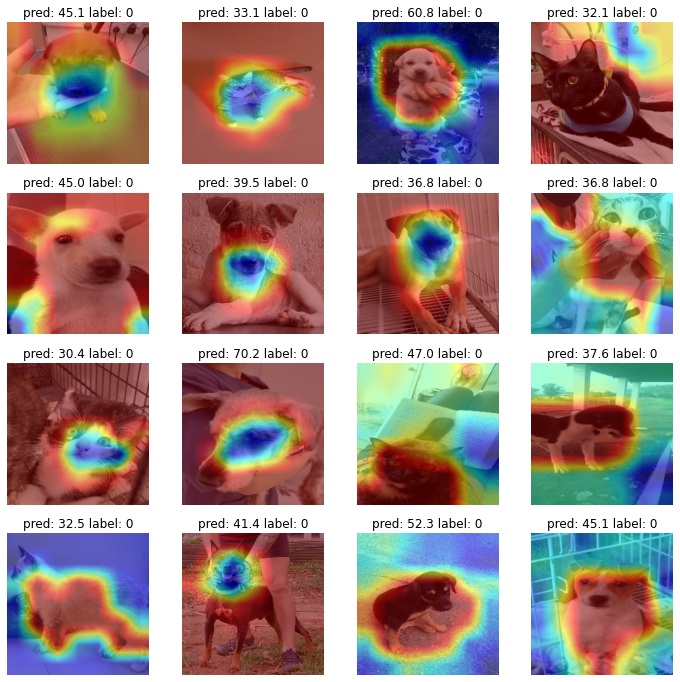

In [12]:
plt.figure(figsize=(12, 12))
for it, (image, grayscale_cam, pred, label) in enumerate(zip(images, grayscale_cams, preds, labels)):
    plt.subplot(4, 4, it + 1)
    visualization = show_cam_on_image(image, grayscale_cam)
    plt.imshow(visualization)
    plt.title(f'pred: {pred:.1f} label: {label}')
    plt.axis('off')